k=3


100%|██████████| 100/100 [00:32<00:00,  3.12it/s]
/Users/samsuidman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsuidman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
/Users/samsuidman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsuidman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in true_divide


k=5


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


k=10


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


k=12


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


k=15


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


k=20


100%|██████████| 100/100 [01:28<00:00,  1.14it/s]


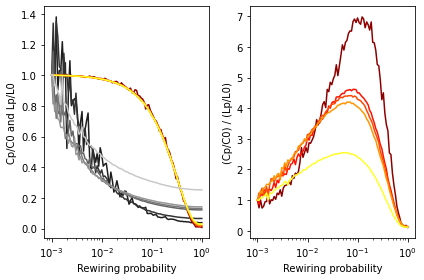

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange,tqdm
from scipy.sparse.csgraph import dijkstra
from scipy.linalg import circulant
import itertools

# problem 2a
def problem_2a(n,m,printen,plotten):
    A = np.zeros(n**2)
    A[:m] = 1
    np.random.shuffle(A)
    A = np.reshape(A,[n,n])
    A_sum = np.sum(A,axis=0)
    C = A_sum/n
    if printen:
        print(A)
    if plotten:
        plt.figure()
        plt.hist(C,bins=10)
        plt.show()
    return A

def problem_2b(n,printen,plotten):
    A = np.random.choice([0,1],size=[n,n],p=[770/870,100/870])
    A_sum = np.sum(A,axis=0)
    C = A_sum/n
    if printen:
        print(A)
    if plotten:
        plt.figure()
        plt.hist(C,bins=10)
        plt.show()
        return A

def problem_2c(n,k,printen):
    A_array = np.zeros(n) # the first row that forms the circulant matrix 
    A_array[-int(k/2):] = 1 
    A_array[1:int(k/2)+1] = 1
    A = np.transpose(circulant(A_array)) # create a circulant matrix from the array and transpose it
    if printen:
        print(A)
    return A

def problem_2d(A,p,printen):    
    indices_1 = np.array(np.where(A==1)) # indices where the matrix is 1
    n_shuffle = int(indices_1.shape[1]*p/2) # rewire a fraction of these indices, because the matrix is symmetrical there are need to be shuffled p/2 values for the upple triangle
    upper_indices_1 = np.array([indices_1[0,np.where(indices_1[1]>indices_1[0])][0],indices_1[1,np.where(indices_1[1]>indices_1[0])][0]]) # look only at upper triangle indices
    n_1 = upper_indices_1.shape[1] #look at amount of upper triangle indices
    i_1 = np.random.choice(np.arange(n_1),size=n_shuffle,replace=False) # pick n_shuffle random indices where the matrix is 1
    x_1,y_1 = upper_indices_1[0,i_1],upper_indices_1[1,i_1] # get the x,y-index of the elements to be shuffled

    indices_0 = np.array(np.where(A==0)) # indices where the matrix is 1
    upper_indices_0 = np.array([indices_0[0,np.where(indices_0[1]>indices_0[0])][0],indices_0[1,np.where(indices_0[1]>indices_0[0])][0]]) # look only at upper triangle indices
    n_0 = upper_indices_0.shape[1] #look at amount of upper triangle indices
    i_0 = np.random.choice(np.arange(n_0),size=n_shuffle,replace=False) # pick n_shuffle random indices where the matrix is 1
    x_0,y_0 = upper_indices_0[0,i_0],upper_indices_0[1,i_0] # get the x,y-index of the elements to be shuffled

    A[x_1,y_1] = 0 # replace ones by zeros
    A[y_1,x_1] = 0 # make the matrix symmetrical
    A[x_0,y_0] = 1 # replace zeros by ones
    A[y_0,x_0] = 1 # make the matrix symmetrical
    if printen:
        print(A)
    return A

def problem_2e(A): 
    n = len(A)
    C_nodes = np.zeros(n)
    for i in range(n): # look at each node
        neighbours = np.nonzero(A[i])[0] # get all neighbours
        neighbours_combinations = np.array(list(itertools.combinations(neighbours,2))) # get all combinations of neighbours
        if len(neighbours_combinations)!=0: # look if there are more than 2 neighbours
            triangles = A[neighbours_combinations[:,0],neighbours_combinations[:,1]] # get the values of the combinations of neighbours where a 1 means a connection (=triangle) and a 0 not
            C_node = np.sum(triangles)/neighbours_combinations.shape[0] # get the local cluster index
        else: # this is the case if there are less than 2 neighbours
            C_node = 0 # set C_node to 0 if it has only 1 neighbours
        C_nodes[i] = C_node
    C = np.mean(C_nodes) # get the average local cluster index
    d_matrix = dijkstra(A) # make shortest path matrix via Dijkstra algorithm
    d_matrix = np.where(d_matrix==np.inf,np.nan,d_matrix)
    d = np.nanmean(d_matrix) # get the mean path length
    return C_nodes,C,d

A_a = problem_2a(n=30,m=100,printen=False,plotten=False)
A_b = problem_2b(n=30,printen=False,plotten=False)
A_c = problem_2c(n=500,k=10,printen=False)
A_d = problem_2d(A=A_c.copy(),p=0.05,printen=False)
C_nodes_e,C_e,d_e = problem_2e(A=A_d)


T = 100
n = 1000
k_array = np.array([3,5,10,12,15,20])
probs = 1/10**np.linspace(0,5,T)[::-1]
C_nodes = np.zeros([len(k_array),T,n])
C = np.zeros([len(k_array),T])
d = np.zeros([len(k_array),T])

fig,ax = plt.subplots(ncols=2)
for i,k in enumerate(k_array):
    print('k={}'.format(k))
    A_f = problem_2c(n=n,k=k,printen=False)
    for j,prob in enumerate(tqdm(probs)): 
        A = problem_2d(A=A_f.copy(),p=prob,printen=False)
        C_nodes[i,j],C[i,j],d[i,j] = problem_2e(A=A)
    
    ax[0].plot(probs,C[i]/C[i,0],color=plt.cm.hot(k*10))
    ax[0].plot(probs,d[i]/d[i,0],color=plt.cm.gray(k*10))
    ax[0].set_xscale('log')
    ax[0].set_xlabel('Rewiring probability')
    ax[0].set_ylabel('Cp/C0 and Lp/L0')

    ax[1].plot(probs,(C[i]/C[i,0])/(d[i]/d[i,0]),color=plt.cm.hot(k*10))
    ax[1].set_xlabel('Rewiring probability')
    ax[1].set_ylabel('(Cp/C0) / (Lp/L0)')
    ax[1].set_xscale('log')
fig.tight_layout()
plt.show()



